In [1]:

from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [2]:
acmccs_apr3_df = pd.read_csv("../traindata/ACMCCS/meta_apr3.csv")
acmccs_apr3_df.fillna("-", inplace=True)
acmccs_apr3_df = acmccs_apr3_df.astype(str)
acmccs_apr3_df['Source link'] = acmccs_apr3_df['Source link'].apply(lambda x: x.replace("youtu.be", "youtube.com").replace("www.youtube.com", "youtube.com"))
# print(supcon_feb07_df.head)


In [3]:
acmccs_apr3_df['group'].unique()

array(['AIHUB', 'LibriSpeech', 'VCTK', 'Elevenlabs', 'DDDM-VC', 'MeloTTS',
       'VITS-TTS', 'SeamlessM4T-TTS', 'MMSTTS', 'DiffGAN', 'VITS-VC',
       'Diff-HierVC', 'Tortoise-TTS', 'StarGANv2-VC', 'OpenVoice',
       'StyleTTS2', 'SNS2024', 'SNS2023'], dtype=object)

### all fake families

In [3]:
score_filelist = os.listdir('./docs/families/')
print(score_filelist)

['MeloTTS_epoch55.txt', 'VITS-VC_epoch15.txt', 'Diff-HierVC_epoch16.txt', 'OpenVoice_epoch20.txt', 'MMSTTS_epoch31.txt', 'Elevenlabs_epoch22.txt', 'Tortoise-TTS_epoch20.txt', 'StarGANv2-VC_epoch14.txt', 'DiffGAN_epoch40.txt', 'StyleTTS2_epoch24.txt', 'SeamlessM4T-TTS_epoch16.txt', 'DDDM-VC_epoch32.txt', 'VITS-TTS_epoch36.txt']


In [6]:
['trainset']+list(acmccs_apr3_df['group'].unique())

['trainset',
 'AIHUB',
 'LibriSpeech',
 'VCTK',
 'Elevenlabs',
 'DDDM-VC',
 'MeloTTS',
 'VITS-TTS',
 'SeamlessM4T-TTS',
 'MMSTTS',
 'DiffGAN',
 'VITS-VC',
 'Diff-HierVC',
 'Tortoise-TTS',
 'StarGANv2-VC',
 'OpenVoice',
 'StyleTTS2',
 'SNS2024',
 'SNS2023']

In [4]:
len([filter]+[0.0]*len(acmccs_apr3_df['group'].unique()))

19

In [101]:
final_df = pd.DataFrame(columns=['trainset']+list(acmccs_apr3_df['group'].unique()))
for score_file in tqdm(score_filelist):
    trainset = score_file.split('_')[0]
    print(trainset)
    # initialize the coresponding row, trainset is the trainset
    final_df.loc[len(final_df)] = [trainset]+[0]*len(acmccs_apr3_df['group'].unique())
    pred_df = pd.read_csv('./docs/families/'+score_file, sep=' ', header=None)
    pred_df.columns = ["utt","spoof","score"]

    pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

    # if spoof < score, then bonafide, else spoof
    pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

    # merge eval_df and pred_df on utt
    res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
    print(len(res_df))
    # print("False Positive") 
    filter = 'group'
    groups = res_df['group'].unique()
    for group in groups:
        num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
        num_total = res_df[res_df[filter]==group].shape[0]
        # update the final_df
        final_df.loc[final_df['trainset']==trainset, group] = 100.0 - num_misclass/num_total*100
        # print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
        
    # print("False negative")
    for group in groups:
        num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
        num_total = res_df[res_df[filter]==group].shape[0]
        # update the final_df
        final_df.loc[final_df['trainset']==filter, group] = 100.0 - num_misclass/num_total*100
        # print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
        

  0%|          | 0/13 [00:00<?, ?it/s]

MeloTTS
72090


  8%|▊         | 1/13 [00:00<00:09,  1.28it/s]

VITS-VC
68890


 15%|█▌        | 2/13 [00:01<00:08,  1.32it/s]

Diff-HierVC
70490


 23%|██▎       | 3/13 [00:02<00:07,  1.30it/s]

OpenVoice
69530


 31%|███       | 4/13 [00:03<00:06,  1.31it/s]

MMSTTS
70810


 38%|███▊      | 5/13 [00:03<00:06,  1.30it/s]

Elevenlabs
65690


 46%|████▌     | 6/13 [00:04<00:05,  1.34it/s]

Tortoise-TTS
64090


 54%|█████▍    | 7/13 [00:05<00:04,  1.37it/s]

StarGANv2-VC
68890


 62%|██████▏   | 8/13 [00:05<00:03,  1.37it/s]

DiffGAN
72890


 69%|██████▉   | 9/13 [00:06<00:02,  1.35it/s]

StyleTTS2
71610


 77%|███████▋  | 10/13 [00:07<00:02,  1.34it/s]

SeamlessM4T-TTS
70170


 85%|████████▍ | 11/13 [00:08<00:01,  1.32it/s]

DDDM-VC
70490


 92%|█████████▏| 12/13 [00:09<00:00,  1.31it/s]

VITS-TTS
67130


100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


In [5]:
# final_df.drop(columns=['AIHUB', 'LibriSpeech', 'VCTK', 'SNS2023', 'SNS2024'], inplace=True)
# final_df.to_csv('final_df.csv', index=False)
final_df = pd.read_csv('docs/families/final_df.csv')
final_df

,trainset,AIHUB,LibriSpeech,VCTK,Elevenlabs,DDDM-VC,MeloTTS,VITS-TTS,SeamlessM4T-TTS,MMSTTS,DiffGAN,VITS-VC,Diff-HierVC,Tortoise-TTS,StarGANv2-VC,OpenVoice,StyleTTS2,SNS2024,SNS2023
0,MeloTTS,28.256144,0.0,0.0,28.075,100.0000,0.000,86.951220,9.772727,79.791667,89.00,100.000000,97.3125,55.895833,98.291667,78.846154,87.019231,3.566122,40.719424
1,VITS-VC,41.110572,0.0,0.0,100.000,100.0000,100.000,100.000000,100.000000,100.000000,100.00,0.000000,100.0000,99.875000,99.833333,100.000000,100.000000,5.255023,51.584377
2,Diff-HierVC,40.537825,0.0,0.0,100.000,98.6250,100.000,91.646341,99.659091,100.000000,100.00,99.958333,0.0000,97.645833,2.791667,100.000000,100.000000,5.135952,50.400000
3,OpenVoice,40.220957,0.0,0.0,100.000,100.0000,89.625,100.000000,100.000000,100.000000,80.50,100.000000,100.0000,99.875000,100.000000,0.000000,99.807692,5.226749,50.879765
4,MMSTTS,36.609571,0.0,0.0,44.225,99.5625,73.500,99.908537,43.750000,0.000000,99.75,99.958333,99.2500,92.020833,100.000000,91.923077,91.346154,4.518072,42.597968
5,Elevenlabs,19.683664,0.0,0.0,0.000,99.9375,27.875,73.536585,0.738636,69.861111,94.50,100.000000,95.6875,54.750000,92.041667,91.298077,95.192308,4.038772,42.319277
6,Tortoise-TTS,42.886775,0.0,0.0,97.625,94.1250,82.000,91.676829,88.806818,99.652778,78.25,99.958333,49.8125,0.000000,26.500000,98.076923,97.596154,5.189456,53.012967
7,StarGANv2-VC,41.008729,0.0,0.0,100.000,97.4375,99.875,80.731707,97.159091,100.000000,100.00,99.958333,1.6875,90.687500,0.000000,100.000000,100.000000,5.023184,51.289609
8,DiffGAN,39.486289,0.0,0.0,99.925,100.0000,100.000,97.560976,99.943182,100.000000,0.00,100.000000,99.9375,93.583333,100.000000,100.000000,99.038462,4.797048,34.025788
9,StyleTTS2,40.184878,0.0,0.0,99.450,100.0000,88.625,99.939024,100.000000,97.013889,98.50,100.000000,99.9375,93.333333,100.000000,100.000000,0.000000,5.074627,50.217077


In [6]:
# final_df
first_col = final_df.pop('trainset')
# change the order of the columns
first_col = first_col.tolist()
final_df = final_df.reindex(sorted(final_df.columns), axis=1)
# change to accuracy by change all cells to 100 - cell
final_df = 100 - final_df


# add the first column back
final_df.insert(0, 'trainset', first_col)
final_df

,trainset,AIHUB,DDDM-VC,Diff-HierVC,DiffGAN,Elevenlabs,LibriSpeech,MMSTTS,MeloTTS,OpenVoice,SNS2023,SNS2024,SeamlessM4T-TTS,StarGANv2-VC,StyleTTS2,Tortoise-TTS,VCTK,VITS-TTS,VITS-VC
0,MeloTTS,71.743856,0.0000,2.6875,11.00,71.925,100.0,20.208333,100.000,21.153846,59.280576,96.433878,90.227273,1.708333,12.980769,44.104167,100.0,13.048780,0.000000
1,VITS-VC,58.889428,0.0000,0.0000,0.00,0.000,100.0,0.000000,0.000,0.000000,48.415623,94.744977,0.000000,0.166667,0.000000,0.125000,100.0,0.000000,100.000000
2,Diff-HierVC,59.462175,1.3750,100.0000,0.00,0.000,100.0,0.000000,0.000,0.000000,49.600000,94.864048,0.340909,97.208333,0.000000,2.354167,100.0,8.353659,0.041667
3,OpenVoice,59.779043,0.0000,0.0000,19.50,0.000,100.0,0.000000,10.375,100.000000,49.120235,94.773251,0.000000,0.000000,0.192308,0.125000,100.0,0.000000,0.000000
4,MMSTTS,63.390429,0.4375,0.7500,0.25,55.775,100.0,100.000000,26.500,8.076923,57.402032,95.481928,56.250000,0.000000,8.653846,7.979167,100.0,0.091463,0.041667
5,Elevenlabs,80.316336,0.0625,4.3125,5.50,100.000,100.0,30.138889,72.125,8.701923,57.680723,95.961228,99.261364,7.958333,4.807692,45.250000,100.0,26.463415,0.000000
6,Tortoise-TTS,57.113225,5.8750,50.1875,21.75,2.375,100.0,0.347222,18.000,1.923077,46.987033,94.810544,11.193182,73.500000,2.403846,100.000000,100.0,8.323171,0.041667
7,StarGANv2-VC,58.991271,2.5625,98.3125,0.00,0.000,100.0,0.000000,0.125,0.000000,48.710391,94.976816,2.840909,100.000000,0.000000,9.312500,100.0,19.268293,0.041667
8,DiffGAN,60.513711,0.0000,0.0625,100.00,0.075,100.0,0.000000,0.000,0.000000,65.974212,95.202952,0.056818,0.000000,0.961538,6.416667,100.0,2.439024,0.000000
9,StyleTTS2,59.815122,0.0000,0.0625,1.50,0.550,100.0,2.986111,11.375,0.000000,49.782923,94.925373,0.000000,0.000000,100.000000,6.666667,100.0,0.060976,0.000000


In [7]:
#sort the row based on the trainset
final_df = final_df.sort_values(by='trainset')
final_df

,trainset,AIHUB,DDDM-VC,Diff-HierVC,DiffGAN,Elevenlabs,LibriSpeech,MMSTTS,MeloTTS,OpenVoice,SNS2023,SNS2024,SeamlessM4T-TTS,StarGANv2-VC,StyleTTS2,Tortoise-TTS,VCTK,VITS-TTS,VITS-VC
11,DDDM-VC,59.438251,100.0000,16.9375,20.50,0.000,100.0,0.138889,0.000,0.000000,50.545455,94.864048,0.000000,5.333333,0.000000,0.437500,100.0,0.000000,0.416667
2,Diff-HierVC,59.462175,1.3750,100.0000,0.00,0.000,100.0,0.000000,0.000,0.000000,49.600000,94.864048,0.340909,97.208333,0.000000,2.354167,100.0,8.353659,0.041667
8,DiffGAN,60.513711,0.0000,0.0625,100.00,0.075,100.0,0.000000,0.000,0.000000,65.974212,95.202952,0.056818,0.000000,0.961538,6.416667,100.0,2.439024,0.000000
5,Elevenlabs,80.316336,0.0625,4.3125,5.50,100.000,100.0,30.138889,72.125,8.701923,57.680723,95.961228,99.261364,7.958333,4.807692,45.250000,100.0,26.463415,0.000000
4,MMSTTS,63.390429,0.4375,0.7500,0.25,55.775,100.0,100.000000,26.500,8.076923,57.402032,95.481928,56.250000,0.000000,8.653846,7.979167,100.0,0.091463,0.041667
0,MeloTTS,71.743856,0.0000,2.6875,11.00,71.925,100.0,20.208333,100.000,21.153846,59.280576,96.433878,90.227273,1.708333,12.980769,44.104167,100.0,13.048780,0.000000
3,OpenVoice,59.779043,0.0000,0.0000,19.50,0.000,100.0,0.000000,10.375,100.000000,49.120235,94.773251,0.000000,0.000000,0.192308,0.125000,100.0,0.000000,0.000000
10,SeamlessM4T-TTS,68.123591,0.0625,8.2500,0.00,65.775,100.0,13.888889,60.750,0.144231,57.580175,95.579268,100.000000,9.750000,0.192308,14.270833,100.0,4.420732,0.041667
7,StarGANv2-VC,58.991271,2.5625,98.3125,0.00,0.000,100.0,0.000000,0.125,0.000000,48.710391,94.976816,2.840909,100.000000,0.000000,9.312500,100.0,19.268293,0.041667
9,StyleTTS2,59.815122,0.0000,0.0625,1.50,0.550,100.0,2.986111,11.375,0.000000,49.782923,94.925373,0.000000,0.000000,100.000000,6.666667,100.0,0.060976,0.000000


In [8]:
final_df.drop(columns=['AIHUB', 'LibriSpeech', 'VCTK', 'SNS2023', 'SNS2024'], inplace=True)
final_df

,trainset,DDDM-VC,Diff-HierVC,DiffGAN,Elevenlabs,MMSTTS,MeloTTS,OpenVoice,SeamlessM4T-TTS,StarGANv2-VC,StyleTTS2,Tortoise-TTS,VITS-TTS,VITS-VC
11,DDDM-VC,100.0000,16.9375,20.50,0.000,0.138889,0.000,0.000000,0.000000,5.333333,0.000000,0.437500,0.000000,0.416667
2,Diff-HierVC,1.3750,100.0000,0.00,0.000,0.000000,0.000,0.000000,0.340909,97.208333,0.000000,2.354167,8.353659,0.041667
8,DiffGAN,0.0000,0.0625,100.00,0.075,0.000000,0.000,0.000000,0.056818,0.000000,0.961538,6.416667,2.439024,0.000000
5,Elevenlabs,0.0625,4.3125,5.50,100.000,30.138889,72.125,8.701923,99.261364,7.958333,4.807692,45.250000,26.463415,0.000000
4,MMSTTS,0.4375,0.7500,0.25,55.775,100.000000,26.500,8.076923,56.250000,0.000000,8.653846,7.979167,0.091463,0.041667
0,MeloTTS,0.0000,2.6875,11.00,71.925,20.208333,100.000,21.153846,90.227273,1.708333,12.980769,44.104167,13.048780,0.000000
3,OpenVoice,0.0000,0.0000,19.50,0.000,0.000000,10.375,100.000000,0.000000,0.000000,0.192308,0.125000,0.000000,0.000000
10,SeamlessM4T-TTS,0.0625,8.2500,0.00,65.775,13.888889,60.750,0.144231,100.000000,9.750000,0.192308,14.270833,4.420732,0.041667
7,StarGANv2-VC,2.5625,98.3125,0.00,0.000,0.000000,0.125,0.000000,2.840909,100.000000,0.000000,9.312500,19.268293,0.041667
9,StyleTTS2,0.0000,0.0625,1.50,0.550,2.986111,11.375,0.000000,0.000000,0.000000,100.000000,6.666667,0.060976,0.000000


In [118]:
final_df.to_csv('onlyfake_df.csv')

## visualize

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


<Figure size 2520x2160 with 0 Axes>

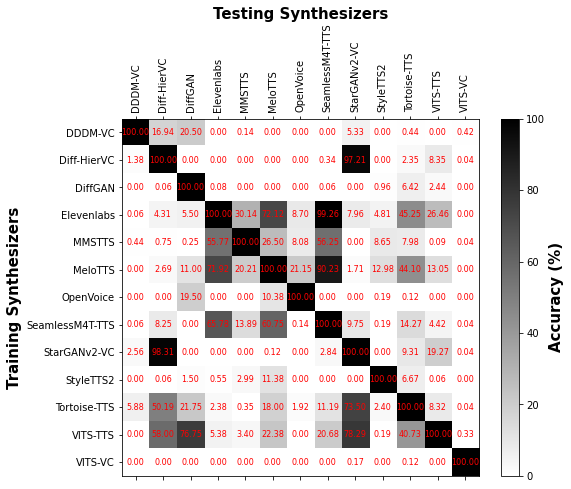

In [10]:
# visulize the data, higher value, darker color
final_df = pd.read_csv('docs/families/onlyfake_df.csv')

plt.figure(figsize=(35,30))

# set font is "Time New Roman"
plt.rcParams["font.family"] = "Times New Roman"

plt.matshow(final_df.iloc[:,1:], cmap='binary')
# add the labels also
plt.xticks(range(final_df.shape[1]-1), final_df.columns[1:], rotation=90)
plt.yticks(range(final_df.shape[0]), final_df['trainset'])
# plt.colorbar()
# x-axis labels
plt.xlabel('Testing Synthesizers', fontsize=15, weight='bold')

# set colorbar size
plt.colorbar(shrink=0.8).set_label('Accuracy (%)', fontsize=15, weight='bold')
# x-axis labels on the top
plt.gca().xaxis.set_label_position('top')
# y-axis labels
plt.ylabel('Training Synthesizers', fontsize=15, weight='bold')

# put the values on the cells
for i in range(final_df.shape[0]):
    for j in range(final_df.shape[1]-1):
        plt.text(j, i, "{:.2f}".format(final_df.iloc[i,j+1]), ha='center', va='center', color='red', fontsize=8)


#extend the margin of the figure to not lose the labels
# plt.subplots_adjust(left=0., right=0.9, top=0.9, bottom=0.1)

# increase the cell size
plt.gcf().set_size_inches(8, 8)

# save the image
plt.savefig('figs/onlyfake_df.pdf',format="pdf", bbox_inches='tight')




### families/dddm_epoch32.txt

70490
70490
70490
Max, Min score:  2.1393930912017822 -1.2625943422317505
False Positive
AIHUB - 8477 - 40.5617%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 4000 - 100.0000%
MeloTTS - 800 - 100.0000%
VITS-TTS - 3280 - 100.0000%
SeamlessM4T-TTS - 1760 - 100.0000%
MMSTTS - 1438 - 99.8611%
DiffGAN - 318 - 79.5000%
VITS-VC - 2390 - 99.5833%
Diff-HierVC - 1329 - 83.0625%
Tortoise-TTS - 4779 - 99.5625%
StarGANv2-VC - 2272 - 94.6667%
OpenVoice - 2080 - 100.0000%
StyleTTS2 - 1040 - 100.0000%
SNS2024 - 68 - 5.1360%
SNS2023 - 680 - 49.4545%
False negative
AIHUB - 0 - 0.0000%
LibriSpeech - 40 - 0.3174%
VCTK - 8 - 0.0965%
Elevenlabs - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 0 - 0.0000%
SNS2023 - 13 - 0.9455%
Accuracy: 50.6710%


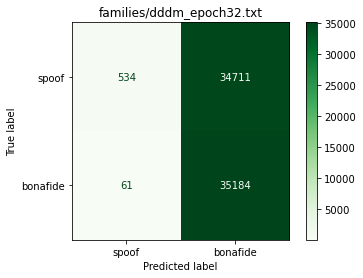

In [9]:
pred_df = pd.read_csv("families/dddm_epoch32.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("families/dddm_epoch32.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### families/diffgan_epoch40.txt

In [ ]:
pred_df = pd.read_csv("families/dddm_epoch32.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("families/dddm_epoch32.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### families/stargan_epoch14.txt

68890
68890
68890
Max, Min score:  2.4354443550109863 -1.309525728225708
False Positive
AIHUB - 8456 - 41.0087%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 4000 - 100.0000%
DDDM-VC - 1559 - 97.4375%
MeloTTS - 799 - 99.8750%
VITS-TTS - 2648 - 80.7317%
SeamlessM4T-TTS - 1710 - 97.1591%
MMSTTS - 1440 - 100.0000%
DiffGAN - 400 - 100.0000%
VITS-VC - 2399 - 99.9583%
Diff-HierVC - 27 - 1.6875%
Tortoise-TTS - 4353 - 90.6875%
OpenVoice - 2080 - 100.0000%
StyleTTS2 - 1040 - 100.0000%
SNS2024 - 65 - 5.0232%
SNS2023 - 696 - 51.2896%
False negative
AIHUB - 0 - 0.0000%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 0 - 0.0000%
SNS2023 - 3 - 0.2211%
Accuracy: 54.0209%


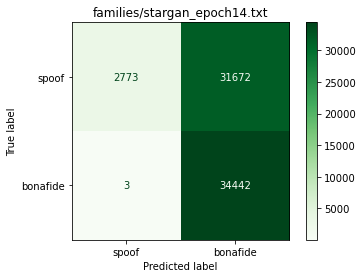

In [5]:
pred_df = pd.read_csv("families/stargan_epoch14.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("families/stargan_epoch14.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### families/mmstts_epoch31.txt

70810
70810
70810
Max, Min score:  2.532159805297852 -1.4933289289474487
False Positive
AIHUB - 7673 - 36.6096%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 1769 - 44.2250%
DDDM-VC - 1593 - 99.5625%
MeloTTS - 588 - 73.5000%
VITS-TTS - 3277 - 99.9085%
SeamlessM4T-TTS - 770 - 43.7500%
DiffGAN - 399 - 99.7500%
VITS-VC - 2399 - 99.9583%
Diff-HierVC - 1588 - 99.2500%
Tortoise-TTS - 4417 - 92.0208%
StarGANv2-VC - 2400 - 100.0000%
OpenVoice - 1912 - 91.9231%
StyleTTS2 - 950 - 91.3462%
SNS2024 - 60 - 4.5181%
SNS2023 - 587 - 42.5980%
False negative
AIHUB - 2 - 0.0095%
LibriSpeech - 98 - 0.7740%
VCTK - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 13 - 0.9789%
SNS2023 - 151 - 10.9579%
Accuracy: 56.7208%


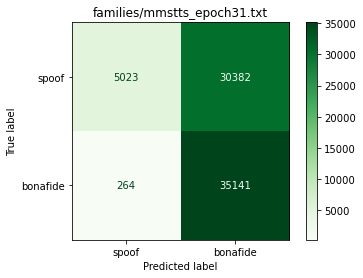

In [7]:
pred_df = pd.read_csv("families/mmstts_epoch31.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("families/mmstts_epoch31.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()